## Only transmon and cavity and chain!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as linalg
import math
import time

# Parameters
d = 0.35 #squid asymmetry
g = 0.08 #transmon cavity coupling
Wq0 = 3.474 #dressed qubit frequency
Wc0 = 7.192 #dressed cavity frequency
lamb_shift  = g**2/(Wc0 - Wq0)
Wc = Wc0 - lamb_shift #bare qubit
Wq = Wq0 + lamb_shift #bare cavity


gamma_L = 0.1 # chain coupling to the left josephson junction
gamma_R = gamma_L*(1-d)/(1+d) # chain coupling to the right josephson junction
t = 0.2 # chain hopping
E_C = 0.06 # charging energy
E_J_max = (Wq+E_C)**2/8/E_C
# E_J1 = 1
# E_J2 = E_J1
n_g = 0
N = 3 # number of chain fermions
n_0 = 10 #number of CP
steps = 100
flux_0 = 2.067833*10**(-15)
flux_array = np.linspace(0,flux_0,steps)
num_of_eigen = 4

max_num_photons = 6 #number of photons



# Defining the single spin operators s_x, s_y, s_z:
s_x = 0.5*np.array([[0,1],[1,0]], dtype=complex)
s_y = 0.5*np.array([[0,-1j],[1j,0]], dtype=complex)
s_z = 0.5*np.array([[1,0],[0,-1]], dtype=complex)

s_plus = s_x + 1j*s_y
s_minus = s_x - 1j*s_y

# Defining the creation and annihilation operators for the SCs
exp_phi_plus = np.diag(np.ones(2*n_0, dtype=complex), k=-1) # Creation
exp_phi_minus = np.diag(np.ones(2*n_0, dtype=complex), k=1)# Annihilation

# harmonic osc creation and annihilation
occupation = np.arange(1,max_num_photons+1, dtype=complex)
a_down = np.diag(np.sqrt(occupation), k=1)
a_up = np.diag(np.sqrt(occupation), k=-1)
occupation_operator = a_up @ a_down

In [5]:

def H_Transmon(E_C = E_C, n_0 = n_0, n_g = n_g, E_J_max = E_J_max, d = d, flux=0): #N is the number of cp passed from one sc to the other
    D = np.zeros(2*n_0+1) #this will be the diagonal
    for i in range(2*n_0+1):
        D[i] = 4*E_C*(-n_0+i-n_g)**2
    H = np.zeros((2*n_0+1,2*n_0+1))
    H = H + np.diag(D) - (E_J_max/2)*np.sqrt(np.cos(np.pi*flux/flux_0)**2 + (d**2)*np.sin(np.pi*flux/flux_0)**2)*(exp_phi_minus + exp_phi_plus)
    return H

def H_cavity(Wc = Wc):
    H = Wc*(a_up @ a_down)
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_cav:", B)
    return H

def H_int_transmon_cavity(g = g, n_0 = n_0, n_g = n_g): # also added the chain's dimension
    D = np.zeros(2*n_0+1) #this will be the diagonal
    for i in range(2*n_0+1):
        D[i] = (-n_0+i-n_g)
    H = g*np.kron(np.diag(D),np.kron((a_down+a_up), np.identity(2**N, dtype=complex)))
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_int_trans_cav:", B)
    return H

def H_Chain(N = N, t = t): # the hamiltonian of the chain alone. N is the number of spins in the system (when we count the up and down spins). t is the tunneling constant
    H_C = np.zeros((2**N,2**N), dtype=complex)
    if N < 3 :
        return np.zeros((2**N, 2**N))
    for i in range(0, N-2, 1):
        term = np.kron(np.identity(2**(i-1+1), dtype=complex),np.kron(s_plus,np.kron(-s_z, np.kron(s_minus,np.identity(2**(N-(i+2+1)), dtype=complex)))))
        H_C += term + term.conj().T # I am adding +1 in all the dimensions because the range starts from 0 and the spin index start from 1
    B = np.sum(np.abs(H_C-np.conj(H_C.T)))
    print("hermitian of H_Chain:", B)
    return -t*H_C

def H_int_transmon_chain(N = N, gamma_L = gamma_L, gamma_R = gamma_R, flux = 0):
    exp_plus = np.exp(1j*np.pi*flux/(2*flux_0)) # should be next to phi_L and -phi_R
    exp_minus = np.conj(exp_plus) # should be next to -phi_L and phi_R
    if N < 3:
        return np.zeros(((2*n_0+1)*(max_num_photons+1)*2**N, (2*n_0+1)*(max_num_photons+1)*2**N), dtype=complex)
    left_term = np.kron(exp_plus*exp_phi_plus, np.kron(np.identity((max_num_photons+1), dtype=complex),np.kron(s_minus,np.kron(s_minus, np.identity(2**(N-2), dtype=complex)))))
    right_term = np.kron(exp_minus*exp_phi_plus, np.kron(np.identity((max_num_photons+1), dtype=complex), np.kron(np.identity(2**(N-2), dtype=complex),np.kron(s_minus, s_minus))))
    H_int = gamma_L * (left_term + left_term.conj().T) + gamma_R * (right_term + right_term.conj().T)
    return H_int

def H_total(flux):
    H = np.kron(H_Transmon(flux=flux), np.kron(np.identity((max_num_photons+1)), np.identity((2**N))))\
        + np.kron(np.identity((2*n_0+1)), np.kron(H_cavity(), np.identity((2**N))))\
        + H_int_transmon_cavity()\
        + np.kron(np.identity((2*n_0+1)), np.kron(np.identity((max_num_photons+1)), H_Chain()))\
        + H_int_transmon_chain(flux=flux)
    B = np.sum(np.abs(H-np.conj(H.T)))
    print("hermitian of H_3:", B)
    return H

tic = time.time()

# test to verify my matrix
# H = H_3(flux[2])
# A = np.sum(np.abs(H - np.conj(H.T)))
# print(A)

n_total = (2*n_0+1)*(max_num_photons+1)*(2**N)

eigenvalues_diff_from_GS = np.zeros((steps,n_total), dtype=complex) # we have num of rows in the size of steps and columns in the size of (2*n_0+1)*(2**N). each row contains all the eigenvalues for specific flux, so each column is a specific eigenvalue for diff fluxes.
eigenvectors_sys = np.zeros((steps,n_total,n_total), dtype=complex)# first dim is steps of flux, 2nd and 3rd dims are for the eigenvectors. so if numpy returns the eigenvectors as a matrix where each column corresponds to eigen-energy, dim 2 is the rows of the matrix and dim 3 is the columns.

for i in range(steps):
    H = H_total(flux = flux_array[i])
    current_eigenvalues, current_eigenvectors = np.linalg.eig(H)
    print(i)
    # sort eigenvalues and rearrange corresponding eigenvectors
    sorted_indices = np.argsort(current_eigenvalues)
    sorted_eigenvalues = current_eigenvalues[sorted_indices]
    sorted_eigenvectors = current_eigenvectors[:, sorted_indices]
    # store results
    eigenvalues_diff_from_GS[i,:] = sorted_eigenvalues-sorted_eigenvalues[0] # the difference from the GS
    eigenvectors_sys[i,:,:] = sorted_eigenvectors

toc = time.time()
print(f"time {toc - tic}s")


hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_Chain: 0.0
hermitian of H_3: 0.0
0
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_Chain: 0.0
hermitian of H_3: 0.0
1
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_Chain: 0.0
hermitian of H_3: 0.0
2
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_Chain: 0.0
hermitian of H_3: 0.0
3
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_Chain: 0.0
hermitian of H_3: 0.0
4
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_Chain: 0.0
hermitian of H_3: 0.0
5
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_Chain: 0.0
hermitian of H_3: 0.0
6
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_Chain: 0.0
hermitian of H_3: 0.0
7
hermitian of H_cav: 0.0
hermitian of H_int_trans_cav: 0.0
hermitian of H_Chain: 0.0
hermitian of H_3: 0.0
8
hermitian of H_cav: 0.0
herm

## Adding an option to cut out a subspace

In [ ]:
def move_operator_to_eigenspace(matrix, step): # matrix is the operator I want to map to the eigenspace, step is the flux number goes from 0 to steps-1 (in the eigenvector matrix the index should be step-1)
    new_matrix = np.linalg.inv(eigenvectors_sys[step,:,:]) @ matrix @ eigenvectors_sys[step,:,:]
    return new_matrix

def cutoff(matrix, sub_system, size_of_subpace): # matrix is the operator I want to cut. sub_system = transmon, cavity, chain. size_of_subspace is the amount of the space I want to leave, ie if transmon and 3 -> i want only the first 3 energies of the transmon subsystem. in the following code i assume that the rest of the subsystem is to be sliced out.
    allowed_values = ['transmon', 'cavity', 'chain']
    if sub_system not in allowed_values:
        raise ValueError(f"Invalid input. Expected one of {allowed_values}, but got {sub_system}")
    if matrix.ndim == 2:
        if sub_system == 'transmon':
            indices_of_transmon = np.array(range(size_of_subpace))
            rest_of_indices = np.array(range((2*n_0+1),n_total))
            indices_to_slice = np.concatenate([indices_of_transmon,rest_of_indices])
            result_submatrix = matrix[indices_to_slice, :][:, indices_to_slice]
            return result_submatrix
        if sub_system == 'cavity':
            indices_of_cavity = np.array(range((2*n_0+1), (2*n_0+1) + size_of_subpace))
            first_indices = np.array(range(2*n_0+1))
            rest_of_indices = np.array(range((2*n_0+1)*(max_num_photons+1),n_total))
            indices_to_slice = np.concatenate([first_indices,indices_of_cavity,rest_of_indices])
            result_submatrix = matrix[indices_to_slice, :][:, indices_to_slice]
            return result_submatrix
        if sub_system == 'chain':
            indices_of_chain = np.array(range(size_of_subpace))
            rest_of_indices = np.array(range((2*n_0+1),n_total))
            indices_to_slice = np.concatenate([indices_of_transmon,rest_of_indices])
            result_submatrix = matrix[indices_to_slice, :][:, indices_to_slice]
            return result_submatrix



In [18]:
import numpy as np

# Create the original matrix
original_matrix = np.array([
    [1, 2, 3, 4, 5, 6],
    [7, 8, 9, 10, 11, 12],
    [13, 14, 15, 16, 17, 18],
    [19, 20, 21, 22, 23, 24],
    [25, 26, 27, 28, 29, 30],
    [31, 32, 33, 34, 35, 36]
])

# Specify the rows and columns to extract
rows_to_extract = [0, 1, 4, 5]
columns_to_extract = [0, 1, 4, 5]

# Use slicing to get the desired submatrix
result_submatrix = original_matrix[rows_to_extract, :][:, columns_to_extract]

print("Desired submatrix:")
print(result_submatrix)

bla = range(5,50)
print(list(bla))
print(np.array(range(3)))


Desired submatrix:
[[ 1  2  5  6]
 [ 7  8 11 12]
 [25 26 29 30]
 [31 32 35 36]]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0 1 2]


In [7]:
import numpy as np

# Sample matrix A
A = np.array([[2, 1], [1, 3]])

# Compute eigenvalues and right eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(A)

# Diagonal matrix of eigenvalues
D = np.diag(eigenvalues)

# Diagonalization using right eigenvectors
A_diagonalized = np.dot(np.dot(np.linalg.inv(eigenvectors), A), eigenvectors)


print("Original Matrix A:")
print(A)

print("\nDiagonalized Matrix A using right eigenvectors:")
print(A_diagonalized)


print("\nmatrix D:")
print(D)


Original Matrix A:
[[2 1]
 [1 3]]

Diagonalized Matrix A using right eigenvectors:
[[ 1.38196601e+00 -1.11022302e-16]
 [ 4.44089210e-16  3.61803399e+00]]

matrix D:
[[1.38196601 0.        ]
 [0.         3.61803399]]


## Plot of the differences from the GS

FileNotFoundError: [Errno 2] No such file or directory: 'energy_diff_from_GS_for_asymmetric_transmon+cavity + chain_amount_of_energies_80_CPnum_10_PhotonsNum_6_chainNum_3.png'

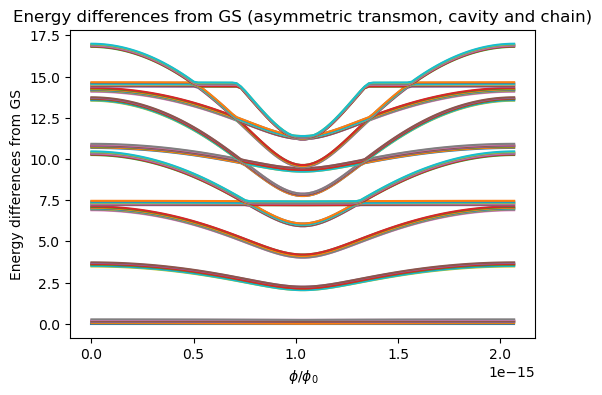

In [9]:
fig = plt.figure(figsize=(6, 4))
energies = 10*2**N
for i in range(energies):
    plt.plot(flux_array,np.real(eigenvalues_diff_from_GS[:,i]))

plt.xlabel(r'${\phi}/{\phi_0}$')
plt.ylabel('Energy differences from GS')
plt.title('Energy differences from GS (asymmetric transmon, cavity and chain)')

# Save the figure as an image (e.g., PNG)
filename = f'energy_diff_from_GS_for_asymmetric_transmon+cavity + chain_amount_of_energies_{energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}.png'
plt.savefig(filename)

# plt.legend()
plt.show()
print(eigenvectors_sys)

Now I want to plot the difference between any two energies as a function of the flux E_i-E_j when E_i > E_j. also I want to add a color bar and paint the lines in the graph by the transition probability between the levels i and j that is caused from the transmon-cavity coupling meaning the term (a_down+a_up).
I will first create the transition amplitude matrix - M.

In [8]:
amount_of_energies = 10*2**3
delta_energy = np.zeros((steps,1)) # contains the energy differences, here i will stack the energies
M = np.zeros_like(delta_energy, dtype=complex) # contains the transition probability due to a_down + a_up, here i will stack the probabilities
operator = np.kron(np.identity((2*n_0+1)), np.kron((a_down+a_up), np.identity(2**N))) # that's the operator I want to get the transition probability for

print("should be the total dimension:", operator.shape) # sanity test

for i in range(amount_of_energies-1, -1, -1): # a loop that iterates from 19 to 0 including
    for j in range(i-1, -1, -1): # a loop that iterates from i-1 to 0 including
        diff = eigenvalues_diff_from_GS[:,i] - eigenvalues_diff_from_GS[:,j] # should be an array with number of rows as "steps" and one column
        temp = np.hstack((delta_energy, diff.reshape(-1,1))) # here i stack the diff in the delta_energy matrix and reshape the diff column to (-1,1) meaning I want it to be 1 column and the number of rows i leave for numpy to figure out according to the data
        delta_energy = temp
        temp_expectation_vec = np.zeros((steps,1), dtype=complex) # here I want to save the transition probability from j to i for each step because each step have different eigenvectors
        for step in range(steps):
            vec_i = eigenvectors_sys[step,:,i]
            vec_j = eigenvectors_sys[step,:,j]
            M_ij = vec_i.conjugate().dot(operator.dot(vec_j))
            temp_expectation_vec[step,0] = M_ij
        temp_M = np.hstack((M, temp_expectation_vec.reshape(-1,1)))
        M = temp_M

print(M.shape)
print(delta_energy.shape)
M = M[:, 1:]
M = np.abs(M)
# M = np.log10(M)
delta_energy = delta_energy[:, 1:]
delta_energy = np.abs(delta_energy)


should be the total dimension: (1176, 1176)
(100, 3161)
(100, 3161)


Now I will plot the data with colormap

[0, 1, 2, 3, 4]


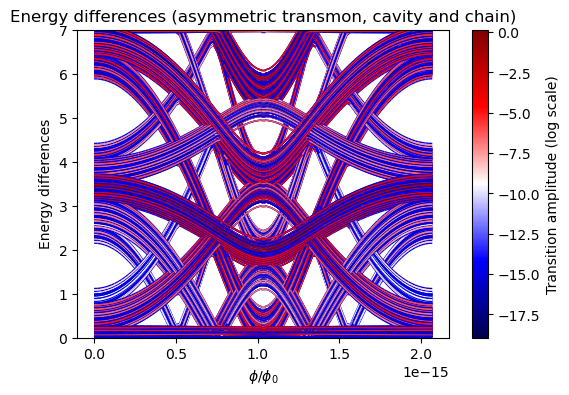

In [10]:
from matplotlib import colors
from matplotlib.cm import get_cmap
from matplotlib.collections import LineCollection


norm = colors.Normalize(vmin=np.min(np.log10(M)),vmax=np.max(np.log10(M))) # normalizes the M values to 0-1
cmap = get_cmap('seismic')
fig, ax = plt.subplots(figsize=(6, 4)) # creates a figure and axes objects. figure contains all the elements of a plot - subplots,titles,labels, legends. axes is an individual plotting area within the fig, this is the plot itself. fig contains the axes (subplots)

for i in range(0, delta_energy.shape[1]):
    points = np.array([flux_array, delta_energy[:,i]]).T.reshape(-1, 1, 2) # shaping the x,y points to a (200,1,2) dim so each entry contains a point x,y
    segments = np.concatenate([points[:-1], points[1:]], axis=1) # points[:-1] removes the last point, points[1:] removes the first point. it only slices along the first dim.
    lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=1) # this object contains the line segments and properties needed to create the lines
    lc.set_array(np.log10(M[:,i])) # used to specify an array of values that will be used to determine the color of each segment in the LineCollection
    ax.add_collection(lc) # add the linecollection to the ax
    if i == 0:
        # Adding colorbar to show the color scale
        cb = plt.colorbar(lc, ax=ax)
        cb.set_label('Transition amplitude (log scale)')

ax.autoscale() #adjusts the axis limits to fit the data in the subplot
# colorbar = plt.colorbar()
# colorbar.set_label('Custom Value')
plt.xlabel(r'${\phi}/{\phi_0}$')
plt.ylabel('Energy differences')
plt.title('Energy differences (asymmetric transmon, cavity and chain)')
plt.ylim(0, 7)
# Include parameter values in the legend without lines
# legend_parameter_values = [f'gamma_L: {gamma_L}', f'gamma_R: {gamma_R}', f'tunneling in the chain: {t}']
# handles = [plt.Line2D([], [], linestyle='None', label=value) for value in legend_parameter_values]
# ax.legend(handles=handles)

# Save the figure as an image (e.g., PNG)
filename = f'energy_diff_for_asymmetric_transmon+cavity+chain_amount_of_energies_{amount_of_energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}.svg'
plt.savefig(filename, dpi = 200)

plt.show()

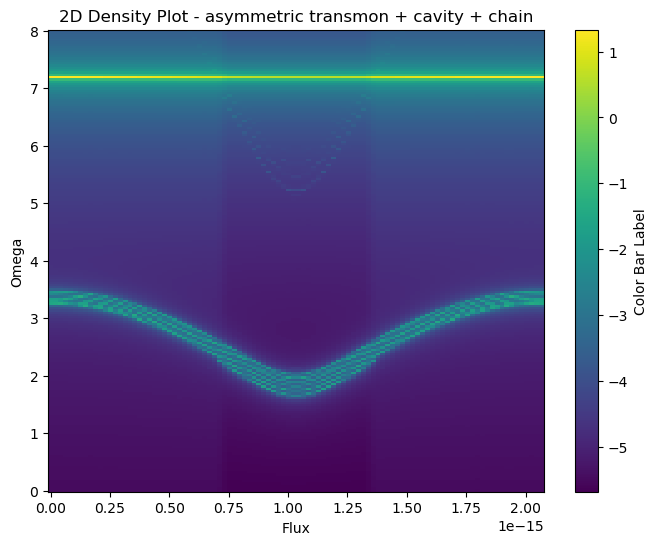

In [12]:
# Generate the flux and omega arrays
omega_array = np.linspace(0,8,num = 200)
kapa = 0.002
# Create a meshgrid of flux and omega values
flux_grid, omega_grid = np.meshgrid(np.pi*flux_array, omega_array)

# Define a function that computes the color value based on flux and omega
def color_function(flux, omega): # flux and omega are 2d arrays where the y-axis (0 axis - rows) is the size of omega_array and the x-axis (1 axis - columns) is the size of flux_array.
    s = np.zeros_like(flux)
    for i in range(omega.shape[0]):
        for j in range(flux.shape[1]):
            temp = 0
            for k in range(M.shape[1]):
                temp += (M[j,k]**2)*(kapa**2)/((delta_energy[j,k]-omega[i,j])**2 + kapa**2)
            s[i,j] = temp
    return s

# Compute the color values for each combination of flux and omega. This is a 2d array of size omega_array X flux_array
color_values = color_function(flux_grid, omega_grid)

# Create a 2D density plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(flux_array, omega_array, np.log10(color_values), cmap='viridis')  # Adjust the colormap as needed
plt.colorbar(label='Color Bar Label')  # Add a color bar for reference
plt.xlabel('Flux')
plt.ylabel('Omega')
plt.title('2D Density Plot - asymmetric transmon + cavity + chain')

# Save the figure as an image (e.g., PNG)
filename = f'density_plot_of_s(w,phi)_amount_of_energies_{energies}_CPnum_{n_0}_PhotonsNum_{max_num_photons}_chainNum_{N}.png'
plt.savefig(filename)

plt.show()
